In [4]:
from torch.utils.data import Dataset, DataLoader
import json
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

### Setting up inputs and outputs

In [5]:
file = '/home/laurie2905/mase_ADL/mase/NASLib/naslib/data/zc_nasbench201.json'
with open(file, 'r') as f:
    data = json.load(f)
    data = data['cifar10']


targets = [data[arch]['val_accuracy'] for arch in data.keys()]
inputs = []

for arch in data.keys():

    inputs.append([data[arch].get(metric_name, 0)['score'] for metric_name in ['epe_nas', 'fisher', 'grad_norm', 'grasp', 'jacov', 'l2_norm', 'nwot','plain','snip','synflow','zen','flops','params'] ])
    

### Defining dataloader with the capacity to only use a portion of data

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class CustomDataset(Dataset):
    def __init__(self, inputs, targets, use_percentage=1.0):
        # Assuming inputs and targets are PyTorch tensors
        assert 0 < use_percentage <= 1, "use_percentage must be within (0, 1)."
        num_samples = int(len(inputs) * use_percentage)
        self.inputs = inputs[:num_samples]
        self.targets = targets[:num_samples]

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]


# Convert lists to PyTorch tensors
inputs = torch.tensor(inputs, dtype=torch.float32)
targets = torch.tensor(targets, dtype=torch.float32).view(-1, 1)


from sklearn.model_selection import train_test_split

# Assuming inputs and targets have been prepared
inputs_train, inputs_test, targets_train, targets_test = train_test_split(
    inputs, targets, test_size=0.2, random_state=42
)

train_dataset = CustomDataset(inputs_train, targets_train, use_percentage= 0.1)
test_dataset = CustomDataset(inputs_test, targets_test, use_percentage = 1)

batch_size = 32  # Adjustable batch size

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Setting up models and training

In [ ]:
# Define the linear model
class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(13, 1)
        # 3 inputs (zc metrics), 1 output (accuracy)

    def forward(self, x):
        return self.linear(x)
    
import torch.nn as nn
import torch.nn.functional as F

class NonLinearModel(nn.Module):
    def __init__(self):
        super(NonLinearModel, self).__init__()
        self.linear1 = nn.Linear(13, 13)  # First linear layer
        self.act1 = nn.ReLU()            # Non-linear activation function
        self.linear2 = nn.Linear(13, 1)  # Second linear layer to produce 1 output

    def forward(self, x):
        x = self.linear1(x)  # Pass input through the first linear layer
        x = self.act1(x)     # Apply non-linear activation
        x = self.linear2(x)  # Pass through the second linear layer
        return x

# model = NonLinearModel()

model = LinearModel()

# Loss and optimizer
criterion = nn.L1Loss()
# criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.01)

# Tracking loss for plotting
train_losses = []
test_losses = []

epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss_train = 0.0
    for inputs_batch, targets_batch in train_loader:
        optimizer.zero_grad()
        outputs_train = model(inputs_batch)
        loss_train = criterion(outputs_train, targets_batch)
        loss_train.backward()
        optimizer.step()
        running_loss_train += loss_train.item() * inputs_batch.size(0)
    
    epoch_loss_train = running_loss_train / len(train_loader.dataset)

    # Evaluation mode (no gradients)
    model.eval()
    running_loss_test = 0.0
    with torch.no_grad():
        for inputs_batch, targets_batch in test_loader:
            outputs_test = model(inputs_batch)
            loss_test = criterion(outputs_test, targets_batch)
            running_loss_test += loss_test.item() * inputs_batch.size(0)

    epoch_loss_test = running_loss_test / len(test_loader.dataset)

    # Save losses for plotting
    train_losses.append(epoch_loss_train)
    test_losses.append(epoch_loss_test)

    if (epoch+1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_loss_train:.4f}, Test Loss: {epoch_loss_test:.4f}')


/home/laurie2905/anaconda3/envs/mase/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Epoch [1/20], Train Loss: 12788.4919, Test Loss: 2.7769
Epoch [2/20], Train Loss: 17.2696, Test Loss: 3.1204
Epoch [3/20], Train Loss: 3.8678, Test Loss: 3.6419
Epoch [4/20], Train Loss: 7.2464, Test Loss: 4.2269
Epoch [5/20], Train Loss: 6.8410, Test Loss: 3.4413
Epoch [6/20], Train Loss: 5.1343, Test Loss: 3.3806
Epoch [7/20], Train Loss: 6.4803, Test Loss: 2.7586
Epoch [8/20], Train Loss: 3.1365, Test Loss: 2.7217
Epoch [9/20], Train Loss: 3.6400, Test Loss: 2.8081
Epoch [10/20], Train Loss: 3.5173, Test Loss: 2.6237
Epoch [11/20], Train Loss: 3.2921, Test Loss: 3.3744
Epoch [12/20], Train Loss: 3.1732, Test Loss: 2.6979
Epoch [13/20], Train Loss: 2.8853, Test Loss: 3.6632
Epoch [14/20], Train Loss: 2.9659, Test Loss: 2.7698
Epoch [15/20], Train Loss: 3.1040, Test Loss: 3.2178
Epoch [16/20], Train Loss: 2.8204, Test Loss: 2.5021
Epoch [17/20], Train Loss: 2.7375, Test Loss: 2.5736
Epoch [18/20], Train Loss: 2.9664, Test Loss: 2.4657
Epoch [19/20], Train Loss: 2.9674, Test Loss: 3.13

### Training loss curve

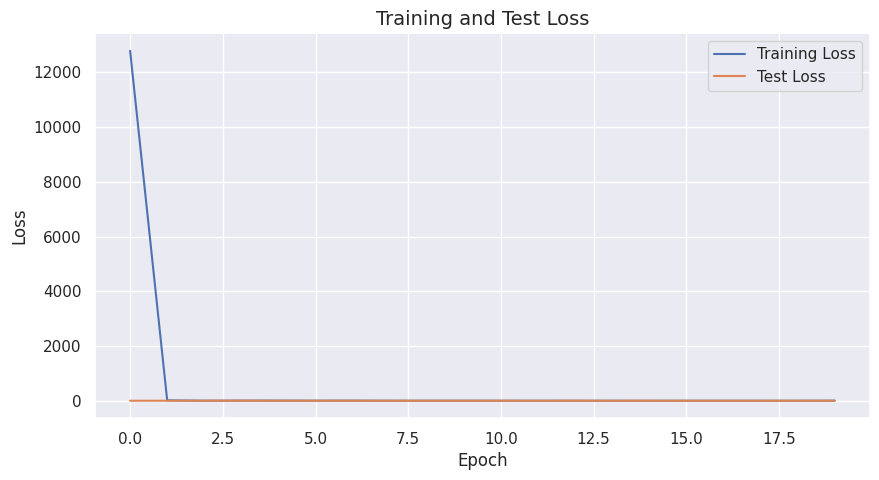

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the Seaborn theme
sns.set_theme(style="darkgrid")

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')

# Add title and labels
plt.title('Training and Test Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)

# Add legend
plt.legend()

# Optionally, set the ylim if you want to focus on a specific range of losses
# plt.ylim([0, 10])

# Show the plot
plt.show()

### Spearman rank coefficient

[87.09816742 86.43510437 88.4156723  ... 88.40435028 85.05078888
 45.30361176]


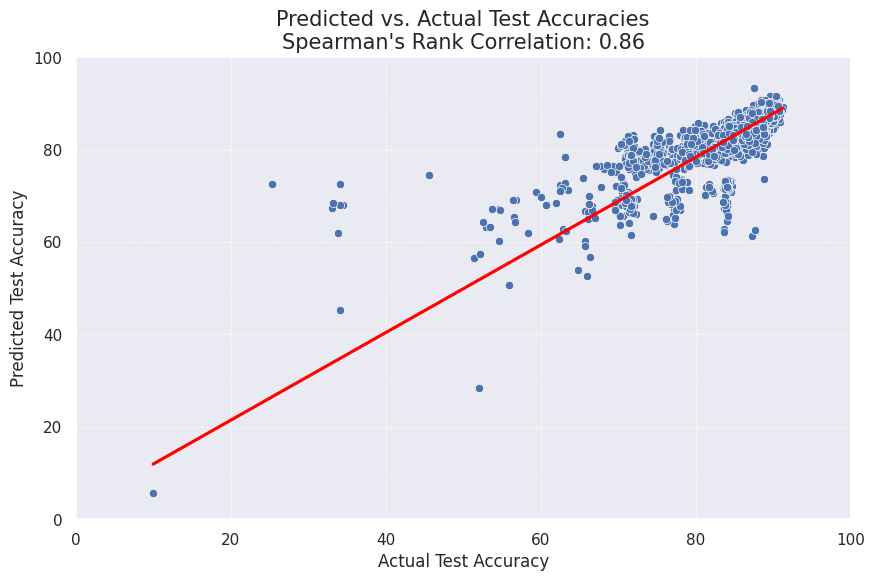

In [ ]:
model.eval()  # Set the model to evaluation mode
predicted_accuracies = []
actual_accuracies = []

with torch.no_grad():  # No need to track gradients
    for i in range(len(inputs_test)):  # Assuming you want to use all test inputs
        predicted_accuracy = model(inputs_test[i].unsqueeze(0))  # Add batch dimension
        predicted_accuracies.append(predicted_accuracy.item())
        actual_accuracies.append(targets_test[i].item())
        
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

# Assuming predicted_accuracies and actual_accuracies are available
predicted_accuracies_np = np.array(predicted_accuracies)
actual_accuracies_np = np.array(actual_accuracies)

print(predicted_accuracies_np)

# Calculate Spearman's rank correlation
spearman_corr, _ = spearmanr(predicted_accuracies_np, actual_accuracies_np)

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Generate a scatter plot
sns.scatterplot(x=actual_accuracies_np, y=predicted_accuracies_np)

# Beautify the plot
plt.title(f'Predicted vs. Actual Test Accuracies\nSpearman\'s Rank Correlation: {spearman_corr:.2f}', fontsize=15)
plt.xlabel('Actual Test Accuracy', fontsize=12)
plt.ylabel('Predicted Test Accuracy', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Optional: Plot a line of best fit
sns.regplot(x=actual_accuracies_np, y=predicted_accuracies_np, scatter=False, ci=None, color="red")
plt.xlim([0, 100])
plt.ylim([0, 100])
plt.show()

### Hyperparameter Tuner

In [38]:
import torch
from torch.utils.data import Dataset, DataLoader

train_dataset = CustomDataset(inputs_train, targets_train, use_percentage= 1)
test_dataset = CustomDataset(inputs_test, targets_test, use_percentage = 1)

In [39]:
import optuna
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader

class DynamicModel(nn.Module):
    def __init__(self, input_size, num_layers, hidden_units, output_size):
        super(DynamicModel, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            in_features = input_size if i == 0 else hidden_units
            self.layers.append(nn.Linear(in_features, hidden_units))
        self.final = nn.Linear(hidden_units, output_size)

    def forward(self, x):
        for layer in self.layers:
            x = torch.relu(layer(x))
        return self.final(x)

def objective(trial):
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    batch_size = trial.suggest_categorical('batch_size', [1, 2, 4, 8, 16, 32, 64])
    num_layers = trial.suggest_int('num_layers', 1, 3)
    hidden_units = trial.suggest_int('hidden_units', 5, 50)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop'])
    loss_function = trial.suggest_categorical('loss_function', ['L1', 'MSE', 'SmoothL1'])

    model = DynamicModel(13, num_layers, hidden_units, 1)
    optimizer = {"Adam": optim.Adam, "RMSprop": optim.RMSprop}[optimizer_name](model.parameters(), lr=lr)
    criterion = {"L1": nn.L1Loss(), "MSE": nn.MSELoss(), "SmoothL1": nn.SmoothL1Loss()}[loss_function]

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model.train()
    for epoch in range(20):
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

    model.eval()
    criterion2 = nn.L1Loss()
    total_loss = 0.0
    n_samples = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion2(outputs, targets)
            total_loss += loss.item() * inputs.size(0)
            n_samples += inputs.size(0)
    avg_loss = total_loss / n_samples

    # Here, save the best model state dict to the trial
    trial.set_user_attr('best_model_state', model.state_dict())

    return avg_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

# Retrieve and save the best model state
best_model_state = study.best_trials[-1].user_attrs['best_model_state']
torch.save(best_model_state, 'best_model.pth')

# Load the best model for prediction
model = DynamicModel(13, study.best_trial.params['num_layers'], study.best_trial.params['hidden_units'], 1)
model.load_state_dict(torch.load('saved_models/best_model.pth'))

print('Best trial (minimizing selected loss function):')
print(f'Value (Loss): {study.best_trial.value}')
print('Params: ')
for key, value in study.best_trial.params.items():
    print(f'{key}: {value}')


[I 2024-03-16 22:50:47,498] A new study created in memory with name: no-name-ac1c93a9-2a64-4199-94d0-8abced0d5784
/tmp/ipykernel_381549/2198445790.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
[I 2024-03-16 22:50:54,433] Trial 0 finished with value: 11.5744372756958 and parameters: {'lr': 6.274080863640892e-05, 'batch_size': 32, 'num_layers': 3, 'hidden_units': 9, 'optimizer': 'Adam', 'loss_function': 'MSE'}. Best is trial 0 with value: 11.5744372756958.
[I 2024-03-16 22:50:57,548] Trial 1 finished with value: 9.041903424987792 and parameters: {'lr': 0.04416224091726432, 'batch_size': 64, 'num_layers': 1, 'hidden_units': 43, 'optimizer': 'RMSprop', 'loss_function': 'L1'}. Best is trial 1 with value: 9.041903424987792.
[I 2024-03-16 22:51:09,952] Trial 2 finished with value:

In [36]:
from torchsummary import summary


# Create a new model instance with the architecture parameters of the best model
model = DynamicModel(
    input_size=13,
    num_layers=study.best_trial.params['num_layers'],
    hidden_units=study.best_trial.params['hidden_units'],
    output_size=1
)

# Load the best model's state dictionary
model.load_state_dict(torch.load('saved_models/best_model.pth'))

model.to('cuda')

# Print the model summary
# You need to know the input size of your model; for example, (13,) for 13 input features
summary(model, input_size=(13,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 5]              70
            Linear-2                    [-1, 5]              30
            Linear-3                    [-1, 1]               6
Total params: 106
Trainable params: 106
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


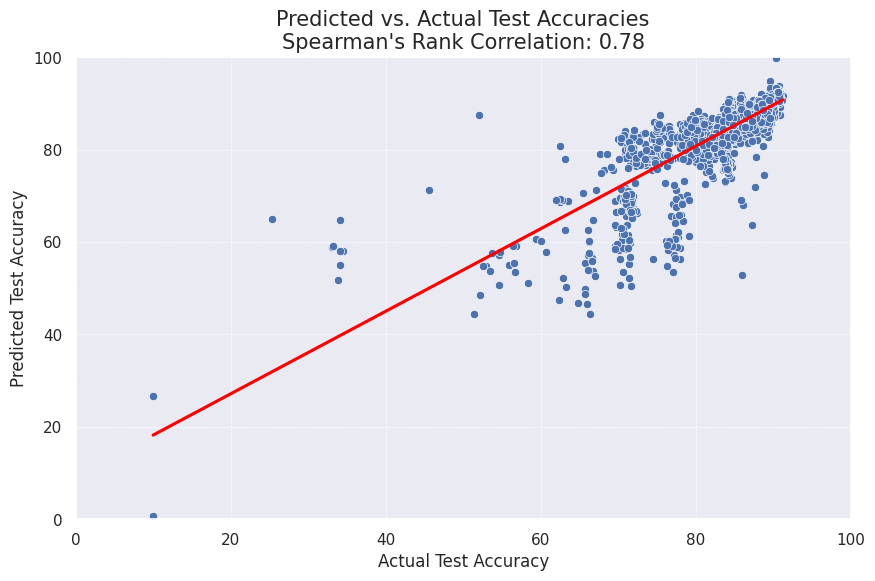

In [37]:
model.eval()  # Set the model to evaluation mode
model.to('cpu')  # Ensure the model is on CPU
predicted_accuracies = []
actual_accuracies = []

with torch.no_grad():  # No need to track gradients
    for i in range(len(inputs_test)):  # Assuming you want to use all test inputs
        input_tensor = inputs_test[i].unsqueeze(0).to('cpu')  # Add batch dimension and ensure it's on CPU
        predicted_accuracy = model(input_tensor)  # Predict
        predicted_accuracies.append(predicted_accuracy.item())
        actual_accuracies.append(targets_test[i].item())

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np  # Ensure numpy is imported
from scipy.stats import spearmanr

# Convert lists to numpy arrays for plotting
predicted_accuracies_np = np.array(predicted_accuracies)
actual_accuracies_np = np.array(actual_accuracies)

# Calculate Spearman's rank correlation
spearman_corr, _ = spearmanr(predicted_accuracies_np, actual_accuracies_np)

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Generate a scatter plot
sns.scatterplot(x=actual_accuracies_np, y=predicted_accuracies_np)

# Beautify the plot
plt.title(f'Predicted vs. Actual Test Accuracies\nSpearman\'s Rank Correlation: {spearman_corr:.2f}', fontsize=15)
plt.xlabel('Actual Test Accuracy', fontsize=12)
plt.ylabel('Predicted Test Accuracy', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Optional: Plot a line of best fit
sns.regplot(x=actual_accuracies_np, y=predicted_accuracies_np, scatter=False, ci=None, color="red")
plt.xlim([0, 100])  # Adjust these limits if necessary
plt.ylim([0, 100])  # Adjust these limits if necessary
plt.show()


## Evaluation on model transfer to other datasets

If network is trained on CIFAR10 how well do the models to transfer to CIFAR100 without retraining

In [ ]:
file = '/home/laurie2905/mase_ADL/mase/NASLib/naslib/data/zc_nasbench201.json'
with open(file, 'r') as f:
    data = json.load(f)
    data = data['cifar100']


targets = [data[arch]['val_accuracy'] for arch in data.keys()]
inputs = []

for arch in data.keys():

    inputs.append([data[arch].get(metric_name, 0)['score'] for metric_name in ['epe_nas', 'fisher', 'grad_norm', 'grasp', 'jacov', 'l2_norm', 'nwot','plain','snip','synflow','zen','flops','params'] ])
    

In [ ]:
from torchsummary import summary


# Create a new model instance with the architecture parameters of the best model
model = DynamicModel(
    input_size=13,
    num_layers=study.best_trial.params['num_layers'],
    hidden_units=study.best_trial.params['hidden_units'],
    output_size=1
)

# Load the best model's state dictionary
model.load_state_dict(torch.load('saved_models/best_model.pth'))

model.to('cuda')

# Print the model summary
# You need to know the input size of your model; for example, (13,) for 13 input features
summary(model, input_size=(13,))

In [ ]:
model.eval()  # Set the model to evaluation mode
model.to('cpu')  # Ensure the model is on CPU
predicted_accuracies = []
actual_accuracies = []

with torch.no_grad():  # No need to track gradients
    for i in range(len(inputs_test)):  # Assuming you want to use all test inputs
        input_tensor = inputs_test[i].unsqueeze(0).to('cpu')  # Add batch dimension and ensure it's on CPU
        predicted_accuracy = model(input_tensor)  # Predict
        predicted_accuracies.append(predicted_accuracy.item())
        actual_accuracies.append(targets_test[i].item())

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np  # Ensure numpy is imported
from scipy.stats import spearmanr

# Convert lists to numpy arrays for plotting
predicted_accuracies_np = np.array(predicted_accuracies)
actual_accuracies_np = np.array(actual_accuracies)

# Calculate Spearman's rank correlation
spearman_corr, _ = spearmanr(predicted_accuracies_np, actual_accuracies_np)

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Generate a scatter plot
sns.scatterplot(x=actual_accuracies_np, y=predicted_accuracies_np)

# Beautify the plot
plt.title(f'Predicted vs. Actual Test Accuracies\nSpearman\'s Rank Correlation: {spearman_corr:.2f}', fontsize=15)
plt.xlabel('Actual Test Accuracy', fontsize=12)
plt.ylabel('Predicted Test Accuracy', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Optional: Plot a line of best fit
sns.regplot(x=actual_accuracies_np, y=predicted_accuracies_np, scatter=False, ci=None, color="red")
plt.xlim([0, 100])  # Adjust these limits if necessary
plt.ylim([0, 100])  # Adjust these limits if necessary
plt.show()
